# Burned area prediction using Multivariate Regression, ExtraTreesRegressor, RandomForestRegressor and Support Vector Regressor

#### Contributed by: Andrian Hevalo

#### Instalation of packages

In [41]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import VarianceThreshold, RFE, SelectFromModel, SelectKBest, chi2, f_regression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import scale, normalize
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Data reading and encoding month and day columns for regression analysis

In [42]:
data = pd.read_csv("/Users/andrianhevalo/Desktop/HW_1/forestfires.csv")

models_performance = list()

# drop rows with missing values
data.dropna(inplace=True)
data.isna()

# Encode Data
data.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),
                        (1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
data.day.replace(('mon','tue','wed','thu','fri','sat','sun'),
                      (1,2,3,4,5,6,7), inplace=True)

data

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,8,7,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,8,7,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,8,7,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,8,6,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Data Explorative Analysis
## Detecting and removing outliers using z score

The data is very noisy and there are a lot of values that differ a lot from others. Therefore we should clean data and remove those rows with high z score which indicates any data point by finding their relationship with the Standard Deviation and Mean of the group of data points.
We shouldn't remove too many rows from the dataset because then we overfit the model. 
Nearly half of the dataset was cleaned!
I omit all values with z score > 1.85 in order to perform significant regression analysis.

In [43]:
z = np.abs(stats.zscore(data))

clean_data = data[(z < 1.85).all(axis=1)]

# see how many rows have been deleted
print(clean_data.shape)
print(data.shape)

(278, 13)
(517, 13)


## Corelation between observable variable and others

In order to perform significant analysis and obtain good results it is necessary to take correlation into account. Correlation directly defines the modeling performance and it helps to see so said "important columns", those that impact on area but this does not mean that we can omit some columns because of low correlation!

In [44]:
data.drop("area", axis=1).apply(lambda x: x.corr(data.area))

X        0.063385
Y        0.044873
month    0.056496
day      0.023226
FFMC     0.040122
DMC      0.072994
DC       0.049383
ISI      0.008258
temp     0.097844
RH      -0.075519
wind     0.012317
rain    -0.007366
dtype: float64

## Correlation heatmap

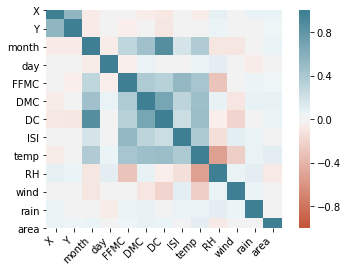

In [45]:
corr = data.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [46]:
y = clean_data['area']

x = clean_data.drop(['area'], axis=1)
clean_data

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
5,8,6,8,7,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.00
6,8,6,8,1,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.00
8,8,6,9,2,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,8,6,8,7,81.6,56.7,665.6,1.9,27.8,35,2.7,0.0,0.00
512,4,3,8,7,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,8,7,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,8,7,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16


## Spliting the dataset into the training set and test set


In [54]:
x_Train, x_Test, y_Train, y_Test = train_test_split(x, y, test_size = 0.3, random_state =42)

# y data reshaping for future scaling
y_Train, y_Test = y_Train.values.reshape(y_Train.size, 1), y_Test.values.reshape(y_Test.size, 1)

## Feature Selection

Since our data is high dimensional we need to perform feature scaling for decreasing model complexity. Feature Selection methods helps with these problems by reducing the dimensions without much loss of the total information. It also helps to make sense of the features and its importance.


F Test is a statistical test used to compare between models and check if the difference is significant between the model.

In [55]:
# Create an SelectKBest object to select features with two best ANOVA F-Values
fvalue_selector = SelectKBest(f_regression, k=7)

# Apply the SelectKBest object to the features and target
x_Train = fvalue_selector.fit_transform(x_Train, y_Train)
x_Test = fvalue_selector.fit_transform(x_Test, y_Test)

## Multivariate Linear Regression

The model below is not significant for this case since r-square is too small which says that our data isn't linear and we need to perform some other regression algorithms

In [56]:
linear_model = LinearRegression()
linear_model.fit(x_Train, y_Train)
y_Prediction = linear_model.predict(x_Test)

# Model Output
# a. Coefficient — the slop of the line
print("Coefficients(slope of the line):", linear_model.coef_)

# c. R-square — how well x accout for the varaince of Y
print("R-square: %.2f’" % r2_score(y_Test, y_Prediction))

models_performance.append(("Multivariate Regression ", r2_score(y_Test, y_Prediction)))

Coefficients(slope of the line): [[ 1.64009622  2.55562727  0.39108004  0.01777605  0.31001696 -0.10195736
   0.87089524]]
R-square: -0.43’


### Cross Validation

In [ ]:
scores = cross_val_score(linear_model, x_Train, y_Train, cv=5)
scores

## ExtraTreesRegressor

In [ ]:
model = ExtraTreesRegressor()
model.fit(x_Train, y_Train)
predictions = model.predict(x_Test)

score = r2_score(y_Test, predictions)

models_performance.append(("ExtraTreesRegressor ", score))

## RandomForestRegressor

In [ ]:
random_forest = RandomForestRegressor()
random_forest.fit(x_Train, y_Train)
random_predictions = random_forest.predict(x_Test)

score = r2_score(y_Test, random_predictions)

models_performance.append(("Random Forest Regressor ", score))

## Support Vector Regressor (SVR)

In [ ]:
# Parameter grid for the Grid Search
param_grid = {'C': [0.01,0.1,1, 10], 'epsilon': [10,1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

svr_model = SVR()

grid_SVR = GridSearchCV(svr_model,
                        param_grid,
                        refit=True,
                        verbose=0,cv=5)

grid_SVR.fit(x_Train, y_Train)

print("Best parameters obtained by Grid Search:", grid_SVR.best_params_)

svr_pred = grid_SVR.predict(x_Test)

score = round(np.sqrt(np.mean((y_Test - svr_pred)**2)), 2)
models_performance.append(("Support Vector Regressor and GridSearchCV ", score))

In [ ]:
models_performance

## Conclusion

'ExtraTreesRegressor' is the most significant estimators/models for this dataset. Support Vector Regressor with non-linear kernel performs bad on this data (with error nearly 16).
#### The r squared for all models is negative which means that regression line is worse than using the mean value!
One of assumptions needed for performing linear regression - data linearity is not working in this case. In other words there are a lot of noise which must be removed. Therefore I cleaned the data and obtain pretty good r square for linear regression!